# Importing the main libraries

In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

# Reading data 

In [5]:
train_df = pd.read_csv("spaceship-titanic/train.csv")
test_df = pd.read_csv("spaceship-titanic/test.csv")
train_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


## First Data analisys

Looking at the firts time to our data we're able to see that we have some categorical columns like:
* HomePlanet
* CryoSleep
* Destination
* VIP

We also have some numerical values, these columns might indicate a kind of social class to us and might indicate some priority on transportation:
* Age
* RoomService
* FoodCourt
* ShoppingMall
* Spa
* VRDeck

The "Cabin" column will divide in three columns to get us a better location insight.




# Processing Data

## Functions to process data

In [7]:
def split_column(df, column_name):

    df_copy = df.copy()
    
    #Splitting the column using '/' as separator
    new_cols = df_copy[column_name].str.split('/', expand=True)
    
    new_cols.columns = ['Deck', 'ChairNumber', 'Side']
    
    # Concatene the new columns
    df_copy = pd.concat([df_copy, new_cols], axis=1)
    
    # Remove the not encoded columns
    df_copy.drop(columns=[column_name], inplace=True)
    
    return df_copy

In [8]:
def check_nan_values(df):
   
    nan_values = df.isna()
    
    df_cleaned = df.dropna()
    
    columns_with_nan = nan_values.any()
    
    columns_with_nan_names = columns_with_nan[columns_with_nan].index.tolist()
    
    if columns_with_nan_names:
        message = f"lines that have a NAN value were deleted from the following columns: {', '.join(columns_with_nan_names)}."
    else:
        message = "There are no NaN values ​​in any column."
    
    return df_cleaned, message

In [9]:
# function to encode categorical data

def label_encoding(df, cols):
    encoded_df = df.copy()
    le = LabelEncoder()
    for col in cols:
        
        encoded_df[col] = encoded_df[col].astype(str)
        encoded_df[col] = le.fit_transform(encoded_df[col])  
    return encoded_df

## Applying functions

In [10]:
train_df, message= check_nan_values(train_df)
message

'lines that have a NAN value were deleted from the following columns: HomePlanet, CryoSleep, Cabin, Destination, Age, VIP, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, Name.'

In [11]:
train_df.shape

(6606, 14)

In [12]:
col = "Cabin"
train_df = split_column(train_df, col)
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,ChairNumber,Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


In [13]:
cols = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Transported","Deck", "ChairNumber", "Side"]
encoded_df = label_encoding(train_df, cols)

In [14]:
encoded_df.pop("Name")
encoded_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,ChairNumber,Side
0,0001_01,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0
1,0002_01,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1,5,0,1
2,0003_01,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,0,1
3,0003_02,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,0,1
4,0004_01,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1,5,1,1


Now we have a cleaned data frame with 6606 rows.
It's a small amount of data. The most plausible is to use ML techniques, but I will also use DL to see how much overfitting I will get. 

### Correlation matrix

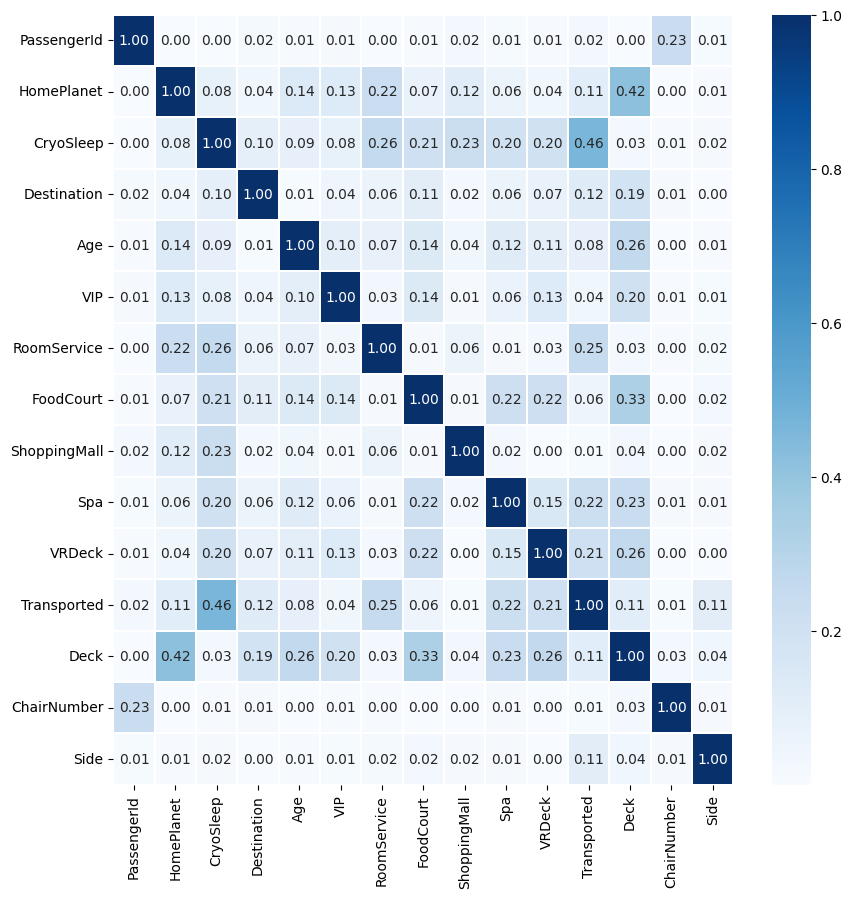

In [15]:
correlations = encoded_df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(abs(correlations), cmap='Blues', linewidths=0.1, annot=True, fmt=f'.2f')
plt.show()

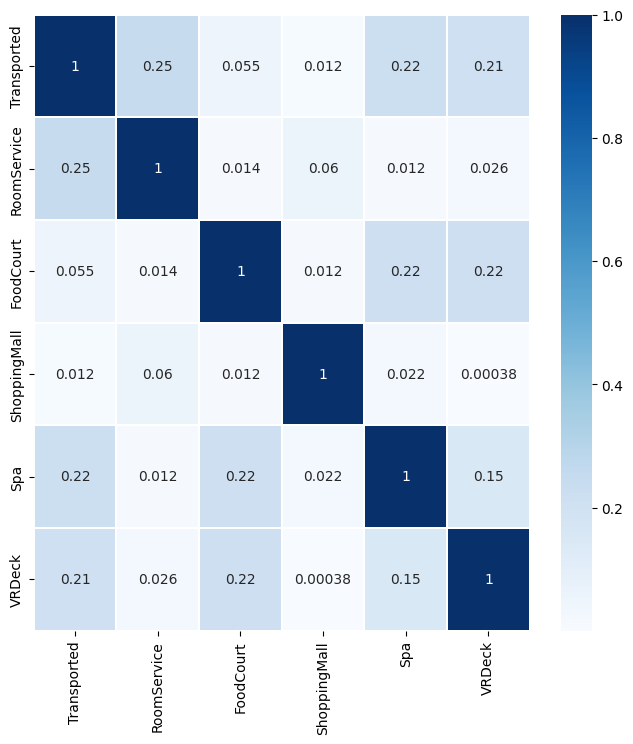

In [16]:
correlations = encoded_df[["Transported","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(abs(correlations), cmap='Blues', linewidths=0.1, annot=True)
plt.show()

At the first moment we can see the most correlated columns to the transported.
* Side
* VRDeck
* SPA
* RoomService
* CryoSleep

There is a Strog indication that the amount spent influenced the transportation. Let's have a look into this building an amount spent column

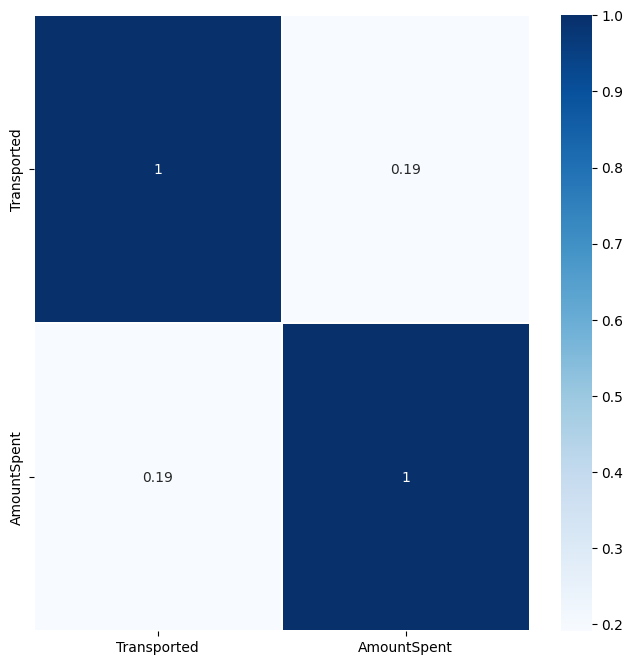

In [17]:
encoded_df["AmountSpent"] = encoded_df[['RoomService', 'FoodCourt', 'ShoppingMall','Spa','VRDeck']].sum(axis=1)

correlations = encoded_df[["Transported","AmountSpent"]].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(abs(correlations), cmap='Blues', linewidths=0.1, annot=True)
plt.show()

The amount correlation is not too strong but I'll keep a separeted Dataframe to test it on the model training

In [18]:
encoded_df_amount = encoded_df.copy()

encoded_df_amount = encoded_df_amount.drop(['RoomService', 'FoodCourt', 'ShoppingMall','Spa','VRDeck'],axis=1)

encoded_df_amount.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Deck,ChairNumber,Side,AmountSpent
0,0001_01,1,0,2,39.0,0,0,1,0,0,0.0
1,0002_01,0,0,2,24.0,0,1,5,0,1,736.0
2,0003_01,1,0,2,58.0,1,0,0,0,1,10383.0
3,0003_02,1,0,2,33.0,0,0,0,0,1,5176.0
4,0004_01,0,0,2,16.0,0,1,5,1,1,1091.0


# Preparing data for training

In [19]:
encoded_df_amount.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
       'Transported', 'Deck', 'ChairNumber', 'Side', 'AmountSpent'],
      dtype='object')

## Splitting feature and label (X,y)

In [20]:
y = encoded_df.Transported.copy()
X = encoded_df.drop(["Transported","PassengerId"], axis=1).copy()

In [21]:
X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,ChairNumber,Side,AmountSpent
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0.0
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,5,0,1,736.0
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,1,10383.0
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,1,5176.0
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,5,1,1,1091.0


### Splitting in Train and validation

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5284, 14), (1322, 14), (5284,), (1322,))

## Normalizing data

In [23]:
norm = StandardScaler()
norm.fit(X_train)

X_train_norm = norm.transform(X_train)
X_val_norm = norm.transform(X_val)

## Getting the class weights

In [24]:
weights = compute_class_weight('balanced', 
                               classes=np.unique(y_train), 
                               y=y_train)
class_weights = {0: weights[0], 1: weights[1]}
class_weights

{0: 1.006092916984006, 1: 0.9939804364183596}

The data we have is balanced, so it's not necessary to apply these weights

# Training the Model

I'll use the Random Forest Classifier as my main ML model

In [25]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train_norm, y_train)

y_pred = rf_classifier.predict(X_val_norm)

accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

print("Classification Report")
print(classification_report(y_val, y_pred))

Accuracy: 0.8169440242057489
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       653
           1       0.83      0.80      0.81       669

    accuracy                           0.82      1322
   macro avg       0.82      0.82      0.82      1322
weighted avg       0.82      0.82      0.82      1322



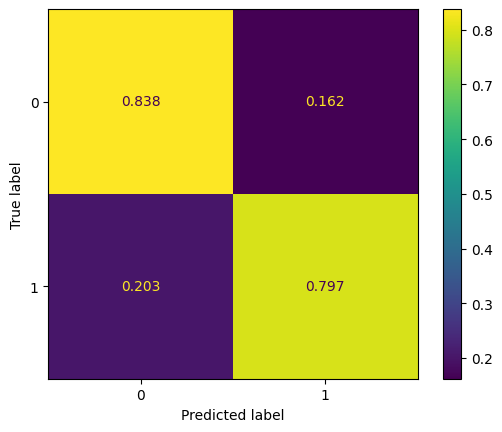

In [26]:
ConfusionMatrixDisplay.from_estimator(rf_classifier, X_val_norm, y_val, 
                                      normalize='true', 
                                      values_format='.3f')
plt.show()

We got a good results at the first instance, let's try get a better result tunning the hyperparameters

## Tuning Hyperparameters

Let's use this function to evaluate our hyperparameters change

In [27]:
def evaluate_model(model, X, y):

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    scores = cross_val_score(model, X, y, scoring='accuracy', 
                             cv=cv)
    return scores

### Max Depth

In [28]:
def get_models():

    models = dict()
    depths = [i for i in range(3, 15)] + [None]
    for n in depths:
        models[str(n)] = RandomForestClassifier(random_state=42,
                                                criterion='entropy',
                                                max_depth=n)
    return models

>3 0.735 (0.016)
>4 0.757 (0.015)
>5 0.776 (0.017)
>6 0.787 (0.015)
>7 0.794 (0.016)
>8 0.799 (0.017)
>9 0.799 (0.016)
>10 0.798 (0.018)
>11 0.799 (0.017)
>12 0.798 (0.017)
>13 0.797 (0.015)
>14 0.796 (0.016)
>None 0.792 (0.015)



C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_141332\4233972365.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names, showmeans=True)


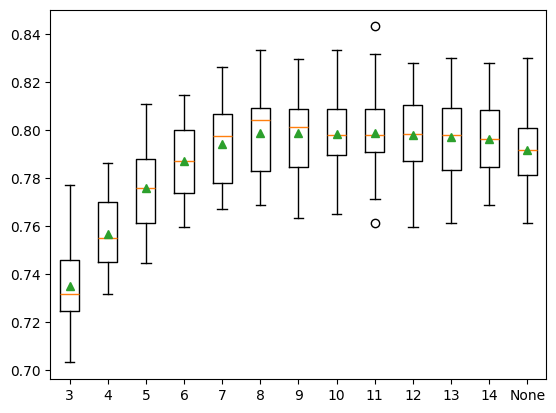

In [29]:
models = get_models()
results, names = list(), list()

for name, model in models.items():

    scores = evaluate_model(model, X_train_norm, y_train)
    results.append(scores)
    names.append(name)
    # print the mean of the scores and the Standard deviation
    print(f'>{name} {np.mean(scores):.3f} ({np.std(scores):.3f})')

print()
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

We can see that 8 for max_depth is best. It has the highest mean and low standard deviation

### N-estimators

In [30]:
def get_models():

    models = dict()
    n_trees = [10, 50, 80, 100, 150, 200]
    for n in n_trees:
        models[str(n)] = RandomForestClassifier(n_estimators=n,
                                                max_depth=8,
                                                criterion='entropy',
                                                random_state=42)
  
    return models

>10 0.792 (0.017)
>50 0.798 (0.015)
>80 0.800 (0.016)
>100 0.799 (0.017)
>150 0.799 (0.016)
>200 0.799 (0.016)


C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_141332\3952346388.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names, showmeans=True)


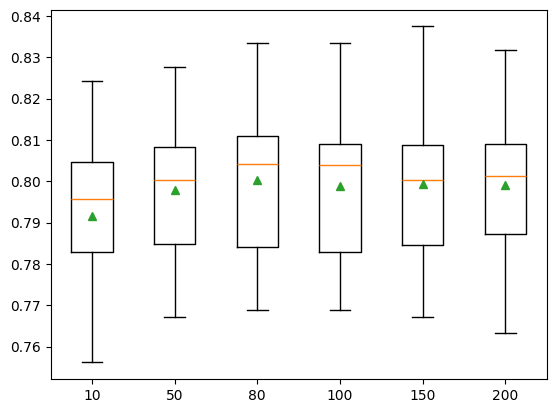

In [31]:
models = get_models()

results, names = list(), list()
for name, model in models.items():

    scores = evaluate_model(model, X_train_norm, y_train)

    results.append(scores)
    names.append(name)
 
    print(f'>{name} {np.mean(scores):.3f} ({np.std(scores):.3f})')
 
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

Here we can see that 80 may be a good number for n_estimators

# Training again

In this case I'll use the class weights too

In [32]:
class_weights

{0: 1.006092916984006, 1: 0.9939804364183596}

In [33]:
rf_classifier_final = RandomForestClassifier(random_state=42,
                                       n_estimators=80,
                                       max_depth=10,
                                       class_weight={0:1.006, 1:0.993})

rf_classifier_final.fit(X_train_norm, y_train)

y_pred = rf_classifier_final.predict(X_val_norm)

accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

print("Classification Report")
print(classification_report(y_val, y_pred))

Accuracy: 0.8116490166414524
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       653
           1       0.82      0.81      0.81       669

    accuracy                           0.81      1322
   macro avg       0.81      0.81      0.81      1322
weighted avg       0.81      0.81      0.81      1322



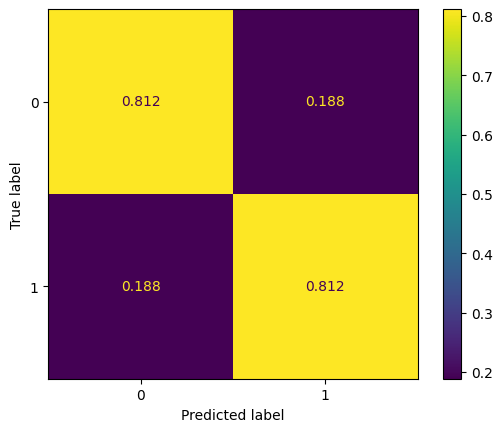

In [34]:
ConfusionMatrixDisplay.from_estimator(rf_classifier_final, X_val_norm, y_val, 
                                      normalize='true', 
                                      values_format='.3f')
plt.show()

# Conclusion

After tunning the hyperparameters we got a more balanced response in our confusion matrix

# Submission


In [38]:
# Load the test dataset
test_df = pd.read_csv('spaceship-titanic/test.csv')

test_df, message= check_nan_values(test_df)

submission_id = test_df.PassengerId

col = "Cabin"
test_df = split_column(test_df, col)

cols = ["HomePlanet", "CryoSleep", "Destination", "VIP","Deck", "ChairNumber", "Side"]
encoded_df_test = label_encoding(test_df, cols)

encoded_df_test = encoded_df_test.drop(["Name","PassengerId"], axis=1)

encoded_df_test["AmountSpent"] = encoded_df_test[['RoomService', 'FoodCourt', 'ShoppingMall','Spa','VRDeck']].sum(axis=1)

X_test_norm = norm.transform(encoded_df_test)

prediction = rf_classifier_final.predict(X_test_norm)
n_predictions = (prediction > 0.5).astype(bool)

output = pd.DataFrame({'PassengerId': submission_id,
                       'Transported': n_predictions.squeeze()})

output.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


# Deep learning

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


# Construindo o modelo
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_norm.shape[1],)),
    Dropout(0.2),  # Dropout para evitar overfitting
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Camada de saída para classificação binária
])

# Compilando o modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Função de perda para classificação binária
              metrics=['accuracy'])

# Treinando o modelo
model.fit(X_train_norm, y_train, epochs=50, batch_size=32, validation_data=(X_val_norm, y_val))

Epoch 1/50


c:\Projetos\RandomForest_Hyperparameter_tunning\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6937 - loss: 0.5756 - val_accuracy: 0.7791 - val_loss: 0.4392
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.7750 - loss: 0.4660 - val_accuracy: 0.7988 - val_loss: 0.4239
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.7886 - loss: 0.4477 - val_accuracy: 0.8018 - val_loss: 0.4175
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.7969 - loss: 0.4432 - val_accuracy: 0.8041 - val_loss: 0.4157
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.7866 - loss: 0.4330 - val_accuracy: 0.8011 - val_loss: 0.4100
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.7980 - loss: 0.4197 - val_accuracy: 0.8124 - val_loss: 0.4088
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.7932 - loss: 0.4386 - val_accuracy: 0.8116 - val_loss: 0.4056
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.7994 - loss: 0.4211 - val_accuracy:

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step


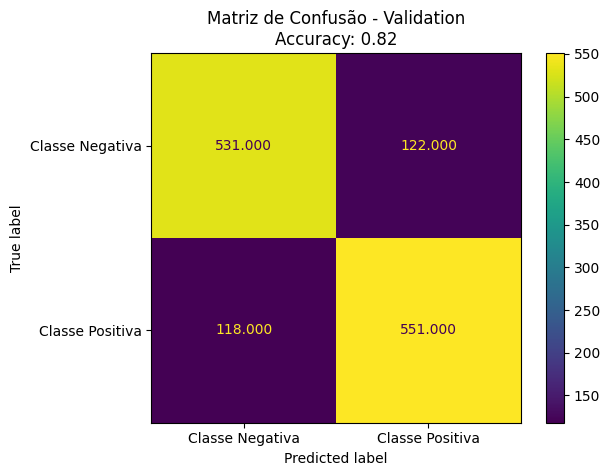

In [40]:
y_pred_val = np.round(model.predict(X_val_norm)).astype(int)

conf_matrix_val = confusion_matrix(y_val, y_pred_val)

accuracy = np.trace(conf_matrix_val) / float(np.sum(conf_matrix_val))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_val, display_labels=['Classe Negativa', 'Classe Positiva'])
disp.plot(values_format='.3f')
plt.title('Matriz de Confusão - Validation\nAccuracy: {:.2f}'.format(accuracy))
plt.show()